<b style='color:red'>
# DRAFT 
</b>
# Capstone Project (Machine Learning Engineer Nanodegree)
## Supervised Learning
## Project: Predicting Red Hat Business Value 
Joaquin Bejar Garcia<br />
15th October 2016

## Definition
_(approx. 1-2 pages)_



### Project Overview

Classify customer potential:

Like most companies, Red Hat is able to gather a great deal of information over time about the behavior of individuals who interact with them. They’re in search of better methods of using this behavioral data to predict which individuals they should approach—and even when and how to approach them.


In this competition, I'm challenged to create a classification algorithm that accurately identifies which customers have the most potential business value for Red Hat based on their characteristics and activities.


With an improved prediction model in place, Red Hat will be able to more efficiently prioritize resources to generate more business and better serve their customers.



### Problem Statement
<b style='color:red'>
In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_</b>


Todos los clientes de Redhat realizan diferentes actividades durante el ciclo de vida de sus productos. Estas actividades muestran tendencias y posibles intereses por parte del cliente de adquirir nuevos productos de la compañia. 

Este estudio al fin y al cabo esta destinado a mejorar el rendimiento del marketing de RedHat mediante una clasificacion del potencial del cliente.

Nuestro objetivo es encontrar un patron que permita identificar a futuras compras por parte de los actuales clientes. Este estudio usa como base de conocimiento un conjunto de datos de clientes que han realizado ciertas acciones y que posteriormente han comprado, nuevos productos.

RedHat proporciona 3 dataset: act_train.csv, act_test.csv and people.csv. Los dataset de training y test vienen con un campo extra de outcome que se puede aplicar como resultado







<b style='color:green'>
I‘m going to write a story how I did it, because knowing why I did it is hard to tell in few words:)

This competition started as a goal to reach top10 for grandmaster title, which ended up with a stressful race for top1 finalle. Luckily, I made some good decisions in the last day which guaranteed me top1 spot. For me this competition was not something I enjoyed very much but still glad everything worked out in the end. My final model is quite simple and if no leak was present, it might have been production friendly. First, proper cross-validation set was very important. Tricks I did to have a representative CV set:

1) Remove observations of group_1=17304, both from train set and test set; That correspons to 30% of training data set, and this group has all outcome=0 (which was used an override rule in making prediction files)

2) Use Distinct operator for gruop_1‘s which have 3000+ number of rows (this step was very important to remove potential auc bias for several of my CV folds)

3) Create random unstratified 5-fold cv set based on people file

My modeling concept was rather simple – reduce original problem to few smaller ones, and combine them in 2nd level model. I have built several models using principles below:

a) Select an activity in each group_1‘s timeline (I used first/last activity in a timeline)

b) Collect all other activities within a group which has the same outcome label

c) Aggregate features – tf-idf was especially useful (in short, for each varriables‘ attribute calculation was done: #of people with same attribute in a group/#of people with same attribute in population)

d) Add other simple and not so simple features (i.e. group_1 id value, #activities in a group, #people in a group, min/max dates etc.); I did not use any feature interactions or likelihood features.

e) Build a classifier on the dataset – I only used xgboost; was able to reach ~0.84 AUC (bare in mind, no leakage has been used till this point yet!) which in my mind was a fantastic result; If I was RedHat, I would have made this as a target to model, but oh, nevermind.

To do it properly I had to think of some novel cross-validation approach as my split was based on people_id, and on this aggregated data level my CV had to be based on some kind of aggregated CV split scheme as well; My approach worked well, but along the way I had to build ~15 xgboost models to make it work (this was necessary to make 2nd level model work). Such proper CV scheme was important, but I‘m not going into details how it works for now.

So at this point I have 4 very well performing 1st level models (2 models which perform very well on public LB, and 2 simillar versions which yield best CV score in 2nd level model); 2nd layer model required very careful scripting skills, as I implemented leakge solution in a cross-validated way, so the predictions of outcome changes within group would be learned in a ML way (simple rules in public scripts are not that good!); So in fact 2nd level model solves 2 problems – predict probabilities imputing observations affected by leakage, and predict probabilities for observations not affected by leakage. The model itself is simple but some smart features were included as well to capture time trends within group/population.

So at this point I have very decent model, and in the middle of competition I see myself at #4 place, and I see top3 guys improving their score day by day. So I put some time into it to think about it & discover that they have been doing some manual exploitation using public LB to increase the leakage. As public/private split was random (took some time to discover), one can use a hand-crafted submissions to test groups not affected by leakage to get auc results for that specific gruop, and determine what the probable outcome of whole group is. Do this for as many submissions taking largest group_1‘s as you can, and you might detect some gruops, that ML model misclassifies badly; having that in mind manually create some overrides based on that; So in my submissions i started using rule-based overrides to corret ML model shortcomings.

For my final submission i used a simple average of my best performing LB model and best performing model on CV – this was my last effort to overtake Victor, and for my surprise it provided very high uplift to my score; I want to thank Victor for not making this easy for me in last few days, as I got myself a little too relaxed at one point:)

p.s. if I did not used any overrides I think I still would have finished within top 5. Sorry for NoHat team, which seems to have made the best ML model there.</b>

### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_

## II. Analysis
_(approx. 2-4 pages)_

In [1]:
import pandas as pd
import sys
import visuals as vs
import renders as rs
from library import *
from cleandf import *



#just ignore the warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.metrics import r2_score, make_scorer
from sklearn import grid_search
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

#import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots
%matplotlib inline

df_act_test = Load_DataFrames('/Data/act_test.csv',1)
df_act_train = Load_DataFrames('/Data/act_train.csv',1)
df_people = Load_DataFrames('/Data/people.csv',1)

df_act_train = df_act_train.fillna(0)
df_act_test = df_act_test.fillna(0)
df_people = df_people.fillna(0)


#df_people = df_people.set_index('people_id')

#df_act_train = df_act_train.sample(n=10000)
#df_people = df_people.sample(n=10000)
#df_act_test = df_act_test.sample(n=10000)


/home/joaquin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/joaquin/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/home/joaquin/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.

### Data Exploration
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_

RedHat proporciona 3 ficheros CSV: act_train.csv, act_test.csv and people.csv. El dataset de training viene con un campo extra de outcome que se aplica como resultado.

El fichero de test es el que deberemos aplicar el algoritmo una vez finalizado el aprendizaje.

El fichero people incluye una serie de campos que permiten clasificar el tipo de perfil que tiene esa persona asi como el grupo al que pertenece, esto proporciona mas informacion a la hora de predecir los resultados de esa persona.

El primer paso es importar y convertir esos ficheros en dataset con los que podamos trabajar. Resulta muy importante limpiar algunos errores en los dataset como por ejemplo algunas personas a las que asigna dos outcomes distintos.


In [2]:
#http://www.programcreek.com/python/example/83782/sklearn.tree.DecisionTreeRegressor

In [3]:
print (df_act_train.shape)
print ("act_train features: {}").format(df_act_train.shape[1])
print ("# of activities: {}").format(df_act_train.shape[0])

display(df_act_train.head())

(2197291, 15)
act_train features: 15
# of activities: 2197291


,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,0,0,0,0,0,0,0,0,0,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,0,0,0,0,0,0,0,0,0,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,0,0,0,0,0,0,0,0,0,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,0,0,0,0,0,0,0,0,0,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,0,0,0,0,0,0,0,0,0,type 1,0


In [4]:
df_act_train['outcome'] = df_act_train['outcome'].astype(int)

In [5]:


print (df_act_train.shape)
print ("act_train features: {}").format(df_act_train.shape[1])
print ("# of activities: {}").format(df_act_train.shape[0])

df_act_train, remove = clean_df_train(df_act_train)

print (df_act_train.shape)
print ("act_train features: {}").format(df_act_train.shape[1])
print ("# of activities: {}").format(df_act_train.shape[0])

outcome = df_act_train['outcome']

display(df_act_train.head())

(2197291, 15)
act_train features: 15
# of activities: 2197291
(1889213, 15)
act_train features: 15
# of activities: 1889213


,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,0,0,0,0,0,0,0,0,0,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,0,0,0,0,0,0,0,0,0,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,0,0,0,0,0,0,0,0,0,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,0,0,0,0,0,0,0,0,0,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,0,0,0,0,0,0,0,0,0,type 1,0


In [6]:
df_act_train = rhclean(df_act_train)
df_act_test = rhclean(df_act_test)

In [7]:
#def find_string(__s):
#    if __s.find("act1") == -1:
#        return(1)
#    else:
#        return(2)
        
#df_act_train["act"] = df_act_train['activity_id'].map(lambda x: find_string(x))

In [8]:

display(df_act_train.head())
display(df_act_test.head())

,people_id,activity_id,date,char_1,char_2,char_3,char_4,char_5,char_6,char_7,...,char_10,outcome,act,ac_1,ac_2,ac_3,ac_4,ac_5,ac_6,ac_7
0,ppl_100,act2_1734928,20230826,0,0,0,0,0,0,0,...,76,0,1,0,0,0,1,0,0,0
1,ppl_100,act2_2434093,20220927,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
2,ppl_100,act2_3404049,20220927,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
3,ppl_100,act2_3651215,20230804,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
4,ppl_100,act2_4109017,20230826,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0


,people_id,activity_id,date,char_1,char_2,char_3,char_4,char_5,char_6,char_7,...,char_9,char_10,act,ac_1,ac_2,ac_3,ac_4,ac_5,ac_6,ac_7
0,ppl_100004,act1_249281,20220720,5,10,5,1,6,1,1,...,4,0,2,1,0,0,0,0,0,0
1,ppl_100004,act2_230855,20220720,0,0,0,0,0,0,0,...,0,682,1,0,0,0,0,1,0,0
2,ppl_10001,act1_240724,20221014,12,1,5,4,6,1,1,...,10,0,2,1,0,0,0,0,0,0
3,ppl_10001,act1_83552,20221127,20,10,5,4,6,1,1,...,5,0,2,1,0,0,0,0,0,0
4,ppl_10001,act2_1043301,20221015,0,0,0,0,0,0,0,...,0,3015,1,0,0,0,0,1,0,0


In [9]:
print (df_people.shape)
print ("People features: {}").format(df_people.shape[1])
print ("# of people: {} \t # of groups: {}").format(df_people.shape[0], len(df_people.drop_duplicates(['group_1']).index))


df_people = clean_df_group(df_people, remove)

display(df_people.head())
display(df_people.describe().round(2))

(189118, 41)
People features: 41
# of people: 189118 	 # of groups: 34224


,people_id,date,group_1,char_1,char_2,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,20210629,17304,2,2,5,5,5,3,11,...,0,1,1,0,0,1,1,1,0,36
1,ppl_100002,20210106,8688,2,3,28,9,5,3,11,...,0,1,1,1,1,1,1,1,0,76
2,ppl_100003,20220610,33592,2,3,4,8,5,2,5,...,0,0,1,1,1,1,0,1,1,99
3,ppl_100004,20220720,22593,2,3,40,25,9,4,16,...,1,1,1,1,1,1,1,1,1,76
4,ppl_100006,20220727,6534,2,3,40,25,9,3,8,...,0,0,1,0,0,0,1,1,0,84


,group_1,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
count,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00,...,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00,182462.00
mean,16643.89,1.92,2.42,18.76,12.76,5.97,2.72,10.94,3.06,3.46,...,0.17,0.21,0.28,0.29,0.22,0.36,0.21,0.34,0.29,49.53
std,10133.19,0.27,0.63,16.00,9.33,2.66,1.49,6.46,1.54,1.94,...,0.37,0.40,0.45,0.45,0.41,0.48,0.41,0.47,0.45,35.93
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,10958.75,2.00,2.00,5.00,6.00,4.00,1.00,7.00,2.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00
50%,17304.00,2.00,2.00,11.00,7.00,5.00,3.00,10.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,56.00
75%,17312.00,2.00,3.00,40.00,25.00,9.00,4.00,16.00,3.00,4.00,...,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,1.00,83.00
max,51462.00,2.00,3.00,44.00,25.00,9.00,7.00,25.00,8.00,9.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,100.00


In [10]:
df_train = pd.merge(df_act_train, df_people, on='people_id', suffixes=('_t',''))
df_test = pd.merge(df_act_test, df_people, on='people_id', suffixes=('_t',''))


display(df_train.head())
display(df_test.head())

,people_id,activity_id,date_t,char_1_t,char_2_t,char_3_t,char_4_t,char_5_t,char_6_t,char_7_t,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,20230826,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,36
1,ppl_100,act2_2434093,20220927,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,36
2,ppl_100,act2_3404049,20220927,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,36
3,ppl_100,act2_3651215,20230804,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,36
4,ppl_100,act2_4109017,20230826,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,36


,people_id,activity_id,date_t,char_1_t,char_2_t,char_3_t,char_4_t,char_5_t,char_6_t,char_7_t,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100004,act1_249281,20220720,5,10,5,1,6,1,1,...,1,1,1,1,1,1,1,1,1,76
1,ppl_100004,act2_230855,20220720,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,76
2,ppl_10001,act1_240724,20221014,12,1,5,4,6,1,1,...,0,1,1,1,1,1,1,1,1,90
3,ppl_10001,act1_83552,20221127,20,10,5,4,6,1,1,...,0,1,1,1,1,1,1,1,1,90
4,ppl_10001,act2_1043301,20221015,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,90


In [11]:
#df_train = df_train[df_train['group_1'] != 17304 ]

In [12]:
display(df_train.loc[df_train['outcome'] == 1].describe().round(2))

display(df_train.loc[df_train['outcome'] == 0].describe().round(2))

,char_1_t,char_2_t,char_3_t,char_4_t,char_5_t,char_6_t,char_7_t,char_8_t,char_9_t,char_10_t,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
count,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00,...,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00,703358.00
mean,0.49,0.37,0.28,0.20,0.26,0.14,0.18,0.37,0.51,540.13,...,0.26,0.31,0.41,0.44,0.32,0.54,0.32,0.52,0.44,78.41
std,2.60,1.84,1.16,0.76,1.12,0.56,0.78,1.58,2.26,1278.36,...,0.44,0.46,0.49,0.50,0.47,0.50,0.47,0.50,0.50,16.95
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,68.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,82.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,452.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,91.00
max,52.00,31.00,11.00,7.00,6.00,5.00,8.00,18.00,19.00,9235.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,100.00


,char_1_t,char_2_t,char_3_t,char_4_t,char_5_t,char_6_t,char_7_t,char_8_t,char_9_t,char_10_t,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
count,918753.00,918753.00,918753.00,918753.00,918753.00,918753.00,918753.00,918753.00,918753.00,918753.00,...,918753.00,918753.0,918753.00,918753.00,918753.00,918753.00,918753.0,918753.00,918753.00,918753.00
mean,0.58,0.43,0.32,0.23,0.29,0.17,0.21,0.43,0.58,468.05,...,0.08,0.1,0.14,0.13,0.11,0.19,0.1,0.17,0.13,24.77
std,2.77,2.01,1.24,0.83,1.16,0.60,0.84,1.70,2.43,1125.43,...,0.27,0.3,0.35,0.34,0.31,0.39,0.3,0.38,0.34,30.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,6.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,433.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,46.00
max,50.00,32.00,11.00,7.00,6.00,5.00,8.00,18.00,19.00,9247.00,...,1.00,1.0,1.00,1.00,1.00,1.00,1.0,1.00,1.00,100.00


In [13]:
print "# of people: {0}".format(df_people.shape[0])
print "# of groups: {0}".format(df_people.drop_duplicates('group_1').shape[0])



# of people: 182462
# of groups: 32438


In [14]:
#cols = df_train.columns.tolist()

#df_train = df_train.drop('outcome', axis=1)

In [15]:
cols = ['people_id', 'activity_id', 'act', 'group_1', 'date', 'date_t', 'char_1_t', 'char_2_t', \
        'char_3_t', 'char_4_t', 'char_5_t', 'char_6_t', 'char_7_t', 'char_8_t', 'char_9_t', \
        'char_10_t', 'ac_1', 'ac_2', 'ac_3', 'ac_4', 'ac_5', 'ac_6', 'ac_7', 'char_1', \
        'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8', 'char_9', \
        'char_10', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17',\
        'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25',\
        'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33',\
        'char_34', 'char_35', 'char_36', 'char_37', 'char_38']

df_train = df_train[cols + ['outcome']]
df_test = df_test[cols]

In [16]:
#Print_Report(df_train,df_test)

In [17]:
print "Extracting features and outcome from DataFrame..."
features = df_train.drop(['outcome','people_id','activity_id'], axis=1)
outcome = df_train['outcome']

df_train_droped = df_train.drop(['people_id','activity_id'], axis=1)

df_test_droped = df_test.drop(['people_id','activity_id'], axis=1)

## Produce a matrix for test data
test_data = df_test.values.tolist()
test_droped = df_test_droped.values.tolist()


Extracting features and outcome from DataFrame...


In [18]:
print "Shuffle and split the data from DataFrame..."
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.01, train_size=0.99, random_state=62)

Shuffle and split the data from DataFrame...


In [19]:


display(X_train.head())

,act,group_1,date,date_t,char_1_t,char_2_t,char_3_t,char_4_t,char_5_t,char_6_t,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
846161,1,17304,20220908,20230727,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,0,2
1343219,1,17304,20200602,20230629,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
175468,1,17304,20200804,20230414,0,0,0,0,0,0,...,0,1,1,1,1,1,0,1,0,43
1267367,1,17304,20220722,20220727,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10558,1,17304,20230511,20230512,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#params = {'criterion': ('gini','entropy')}

# param for Decission trees
params = {'criterion': ['entropy'],
            'max_depth':[58],
            'max_features': (None,'auto'),
            'min_samples_split': [2]}
#params = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
#params = {'kernel': ('linear', 'poly'),
#            'cache_size': [1024]}
            


In [21]:


# Fit the training data to the model using grid search
print "Fit the training data to the model using grid search..."
reg = fit_model(X_train, y_train, params)


Fit the training data to the model using grid search...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.5min finished


Regresor: RandomForestClassifier,	 Score: 0.987677301885


In [22]:
# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 58 for the optimal model.


In [23]:
reg.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 58,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [24]:
display(df_test.head())

,people_id,activity_id,act,group_1,date,date_t,char_1_t,char_2_t,char_3_t,char_4_t,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100004,act1_249281,2,22593,20220720,20220720,5,10,5,1,...,1,1,1,1,1,1,1,1,1,76
1,ppl_100004,act2_230855,1,22593,20220720,20220720,0,0,0,0,...,1,1,1,1,1,1,1,1,1,76
2,ppl_10001,act1_240724,2,25417,20221014,20221014,12,1,5,4,...,0,1,1,1,1,1,1,1,1,90
3,ppl_10001,act1_83552,2,25417,20221014,20221127,20,10,5,4,...,0,1,1,1,1,1,1,1,1,90
4,ppl_10001,act2_1043301,1,25417,20221014,20221015,0,0,0,0,...,0,1,1,1,1,1,1,1,1,90


In [25]:
y_pred = reg.predict(df_test_droped)

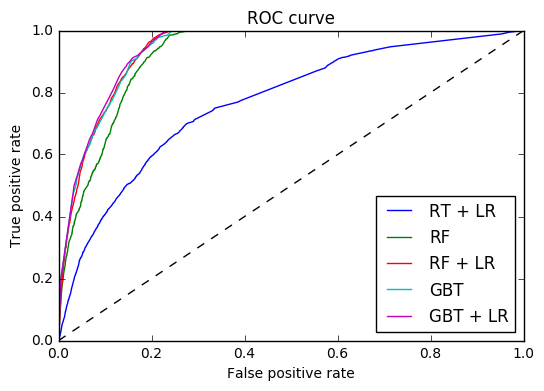

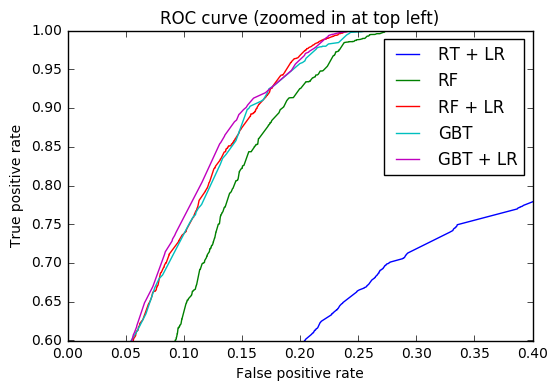

In [26]:
from someclf import *

smclf(X_train, y_train)

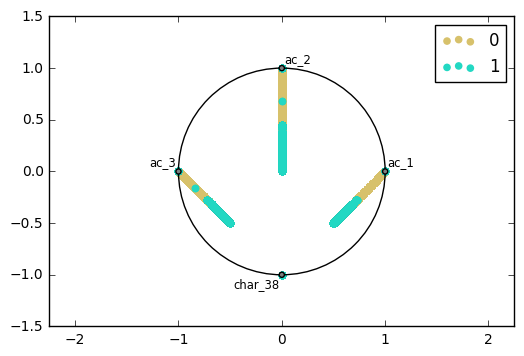

In [27]:
cols = ['group_1','act', 'date', 'date_t', 'char_1_t', 'char_2_t', 'char_3_t', \
            'char_4_t', 'char_5_t', 'char_6_t', 'char_7_t', 'char_8_t', 'char_9_t', \
            'char_10_t', 'ac_1', 'ac_2', 'ac_3', 'ac_4', 'ac_5', \
            'ac_6', 'ac_7', 'char_1', 'char_2', 'char_3', 'char_4', \
            'char_5', 'char_6', 'char_7', 'char_8', 'char_9', 'char_10', 'char_11', \
            'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', \
            'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', \
            'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', \
            'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38','outcome']

data = df_train_droped[['ac_1', 'ac_2', 'ac_3','char_38','outcome']]
#pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

from pandas.tools.plotting import radviz
radviz(data, 'outcome')

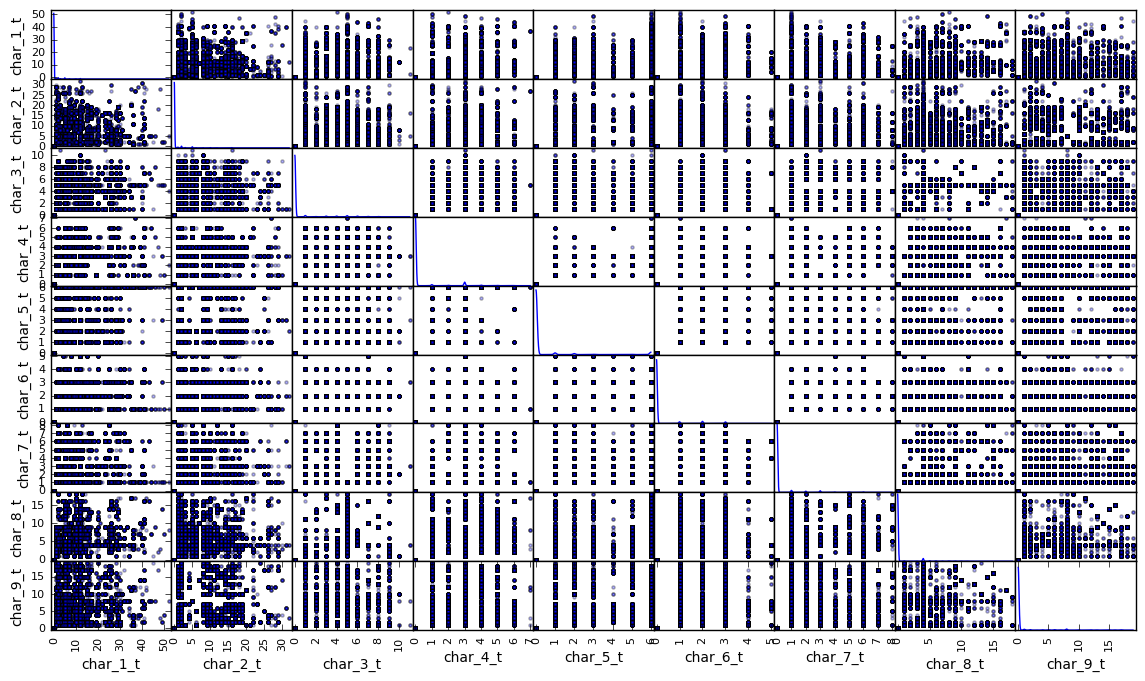

In [28]:
data = df_train_droped[['char_1_t', 'char_2_t', 'char_3_t', \
            'char_4_t', 'char_5_t', 'char_6_t', 'char_7_t', 'char_8_t', 'char_9_t']]
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

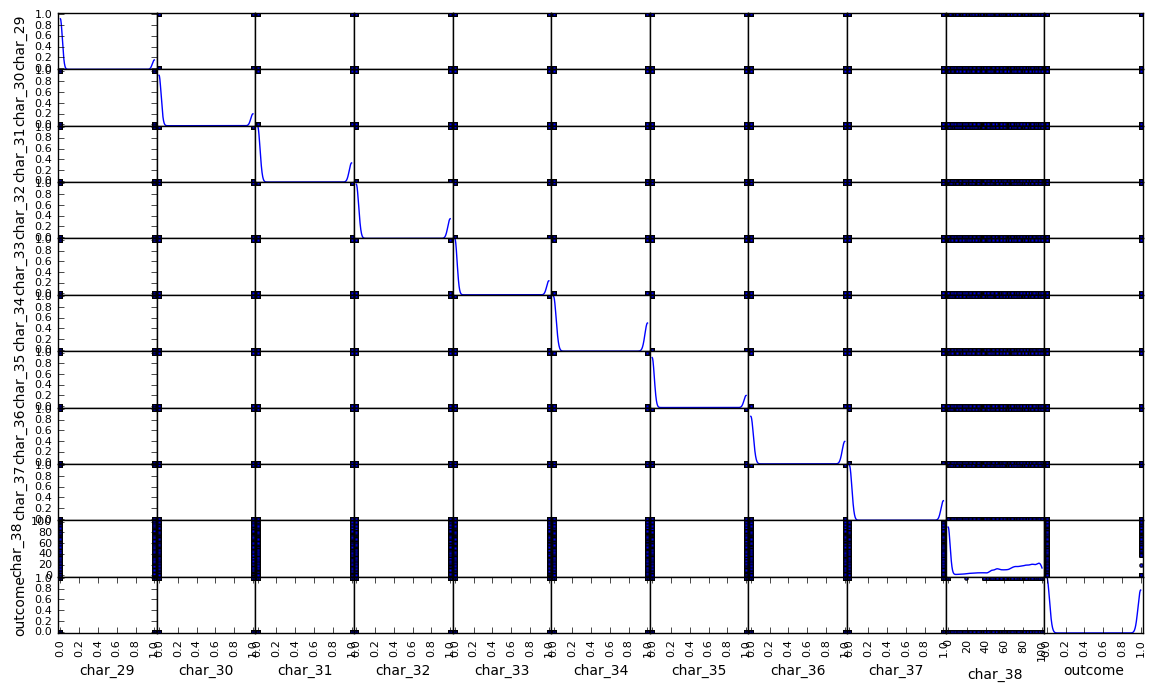

In [29]:
data = df_train_droped[['char_29', 'char_30', 'char_31', 'char_32', \
            'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38','outcome']]
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

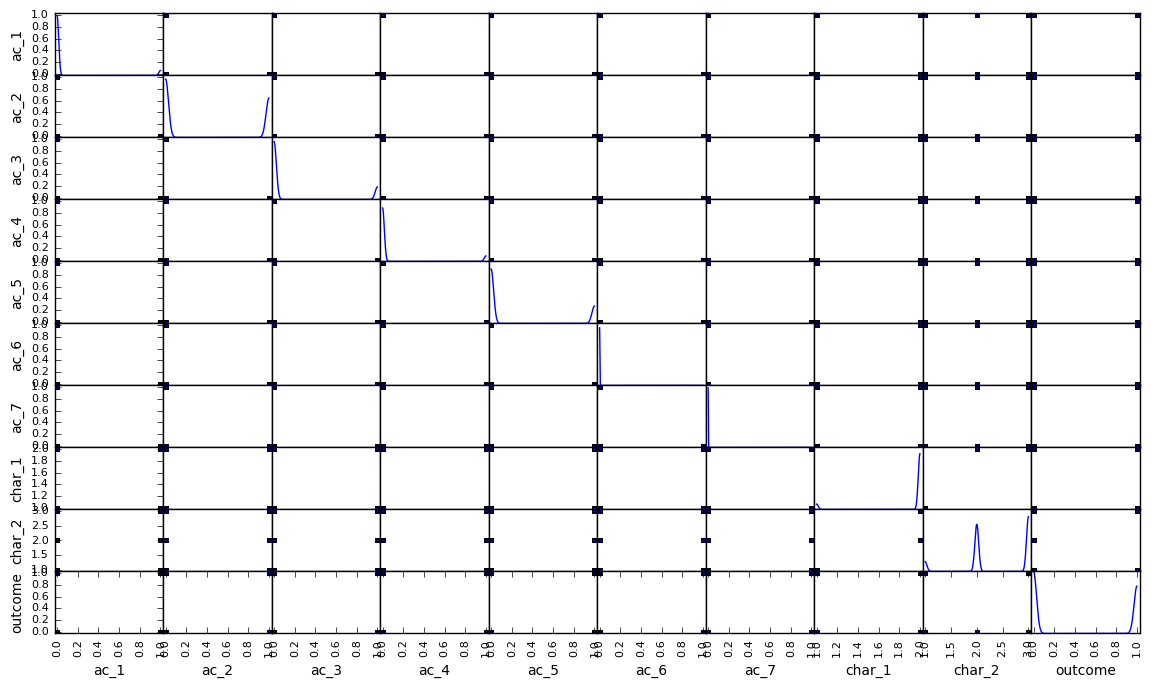

In [30]:
data = df_train_droped[[ 'ac_1', 'ac_2', 'ac_3', 'ac_4', 'ac_5', \
            'ac_6', 'ac_7', 'char_1', 'char_2','outcome']]
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [31]:
CreateSubmission(df_test, y_pred,"RamdonForest")

Saving submission for RamdonForest at 20161025084234...


### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

In [32]:
#from sklearn import tree
#from IPython.display import Image  
#import pydotplus

#dot_data = tree.export_graphviz(reg, out_file=None, 
#                         feature_names=df_test.columns.tolist(),  
#                         class_names=[0,1],  
#                         filled=True, rounded=True,  
#                         special_characters=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png()) 

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_

### Benchmark
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_

## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_


### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_